In [24]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')
import os

In [25]:
df = pd.read_csv('Spotify_Dataset_V3.csv', delimiter=';')
df

,Rank,Title,Artists,Date,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Valence,# of Artist,Artist (Ind.),# of Nationality,Nationality,Continent,Points (Total),Points (Ind for each Artist/Nat),id,Song URL
0,1,Ella Baila Sola,"Eslabon Armado, Peso Pluma",29/05/2023,0.668,0.758,-5176.0,0.033,0.483,0.000,0.834,Artist 1,Eslabon Armado,Nationality 1,Mexico,Latin-America,200,100.0,3qQbCzHBycnDpGskqOWY0E,https://open.spotify.com/track/3qQbCzHBycnDpGs...
1,1,Ella Baila Sola,"Eslabon Armado, Peso Pluma",29/05/2023,0.668,0.758,-5176.0,0.033,0.483,0.000,0.834,Artist 2,Peso Pluma,Nationality 2,Mexico,Latin-America,200,100.0,3qQbCzHBycnDpGskqOWY0E,https://open.spotify.com/track/3qQbCzHBycnDpGs...
2,2,WHERE SHE GOES,Bad Bunny,29/05/2023,0.652,0.800,-4019.0,0.061,0.143,0.629,0.234,Artist 1,Bad Bunny,Nationality 1,Puerto Rico,Latin-America,199,199.0,7ro0hRteUMfnOioTFI5TG1,https://open.spotify.com/track/7ro0hRteUMfnOio...
3,3,La Bebe - Remix,"Yng Lvcas, Peso Pluma",29/05/2023,0.812,0.479,-5678.0,0.333,0.213,0.000,0.559,Artist 1,Yng Lvcas,Nationality 1,Mexico,Latin-America,198,99.0,2UW7JaomAMuX9pZrjVpHAU,https://open.spotify.com/track/2UW7JaomAMuX9pZ...
4,3,La Bebe - Remix,"Yng Lvcas, Peso Pluma",29/05/2023,0.812,0.479,-5678.0,0.333,0.213,0.000,0.559,Artist 2,Peso Pluma,Nationality 2,Mexico,Latin-America,198,99.0,2UW7JaomAMuX9pZrjVpHAU,https://open.spotify.com/track/2UW7JaomAMuX9pZ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651931,197,Oh Lord,MiC LOWRY,01/01/2017,0.273,0.794,-6644.0,0.068,0.022,0.000,0.377,Artist 1,MiC LOWRY,Nationality 1,United Kingdom,Europe,4,4.0,1sTUEdVO85YU8Ymk2jeAls,https://open.spotify.com/track/1sTUEdVO85YU8Ym...
651932,198,Superstition - Single Version,Stevie Wonder,01/01/2017,0.650,0.658,-10908.0,0.085,0.089,0.004,0.883,Artist 1,Stevie Wonder,Nationality 1,United States,Anglo-America,3,3.0,5lXcSvHRVjQJ3LB2rLKQog,https://open.spotify.com/track/5lXcSvHRVjQJ3LB...
651933,199,Secrets,The Weeknd,01/01/2017,0.665,0.771,-5779.0,0.053,0.016,0.000,0.764,Artist 1,The Weeknd,Nationality 1,Canada,Anglo-America,2,2.0,3DX4Y0egvc0slLcLl31h2p,https://open.spotify.com/track/3DX4Y0egvc0slLc...
651934,200,Ni**as In Paris,"JAY-Z, Kanye West",01/01/2017,0.757,0.882,-6125.0,0.248,0.076,0.000,0.684,Artist 1,JAY-Z,Nationality 1,United States,Anglo-America,1,1.0,2KpCpk6HjXXLb7nnXoXA5O,https://open.spotify.com/track/2KpCpk6HjXXLb7n...


In [26]:
df['id'].unique().shape

(9161,)

In [27]:
audio_features = ['Danceability', 'Energy', 'Valence', 'Acousticness', 'Instrumentalness', 'Speechiness', 'Loudness']

df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year

Original full dataset size: 651936
Unique songs dataset size: 9161

Calculating optimal k...


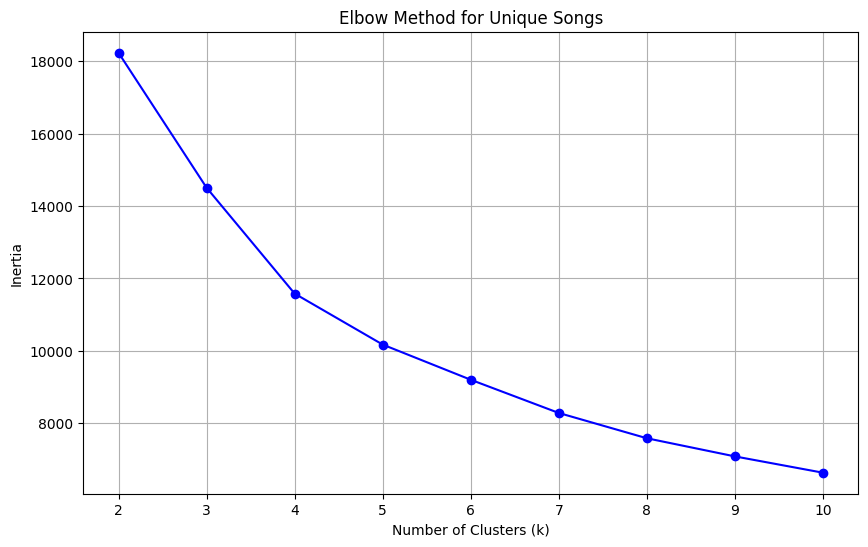

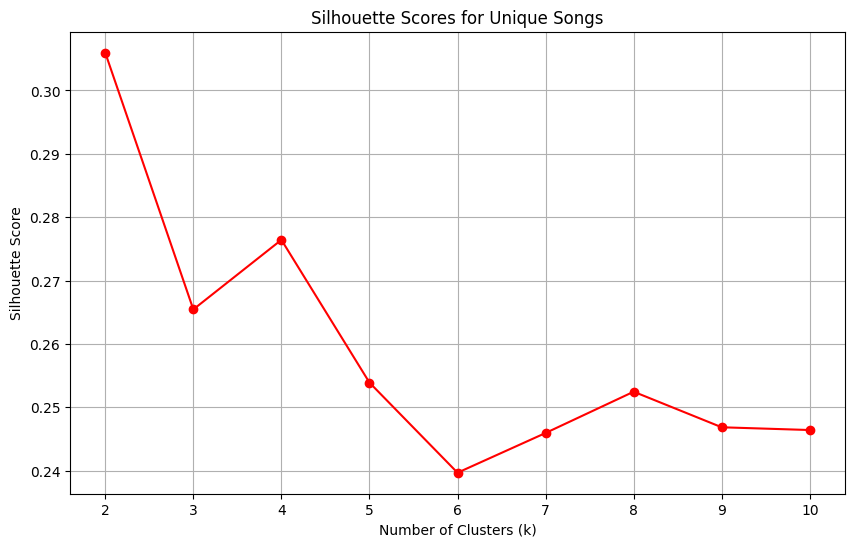

In [28]:
# Set the unique song identifier column
from sklearn.metrics import silhouette_score


SONG_ID_COLS = ['id'] 

audio_features = ['Danceability', 'Energy', 'Valence']

# --- 2. Calculate Deviation Features (on all 650k rows) ---
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
year_avg_features = df.groupby('Year')[audio_features].transform('mean')

df_dev = df[audio_features].sub(year_avg_features)
df_dev.columns = [f'{col}_dev' for col in audio_features]

# Add the dev features and song IDs to one DataFrame
df_full_dev = pd.concat([df[SONG_ID_COLS], df_dev], axis=1)

# --- 3. Create the Unique Song Dataset (Average Deviation) ---
print(f"Original full dataset size: {len(df_full_dev)}")
df_unique_avg_dev = df_full_dev.groupby(SONG_ID_COLS).mean().reset_index()
print(f"Unique songs dataset size: {len(df_unique_avg_dev)}")

# --- 4. Scale the Unique Song Data ---
scaler = StandardScaler()
X_unique_scaled = scaler.fit_transform(df_unique_avg_dev.drop(columns=SONG_ID_COLS))

# --- 5. Find Optimal K (Elbow + Silhouette) ---
k_range = range(2, 11) 
inertia_values = []
silhouette_values = []

print("\nCalculating optimal k...")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_unique_scaled)
    inertia_values.append(kmeans.inertia_)
    silhouette_values.append(silhouette_score(X_unique_scaled, cluster_labels))

# Plot Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia_values, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Unique Songs')
plt.grid(True)
plt.savefig("unique_songs_elbow_plot.png")
plt.show()

# Plot Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_values, 'ro-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Unique Songs')
plt.grid(True)
plt.savefig("unique_songs_silhouette_plot.png")
plt.show()




Cluster counts in the original 650k dataset:
cluster
0    137019
1     74433
2    266900
3    173584
Name: count, dtype: int64


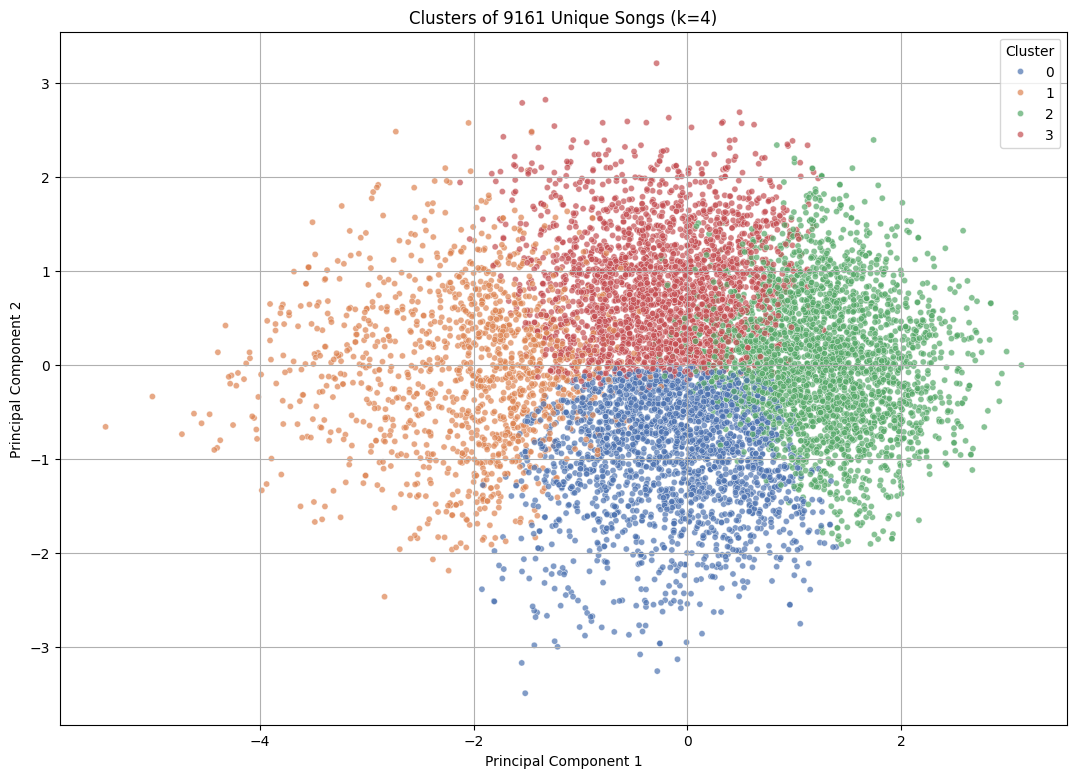

In [29]:
k_final = 4 

kmeans_final = KMeans(n_clusters=k_final, random_state=42, n_init=10)
final_labels = kmeans_final.fit_predict(X_unique_scaled)

# Add cluster labels to the unique songs DataFrame
df_unique_avg_dev['cluster'] = final_labels

# --- 7. Merge Clusters Back to Original 650k DataFrame ---
df = pd.merge(
    df, 
    df_unique_avg_dev[SONG_ID_COLS + ['cluster']], 
    on=SONG_ID_COLS, 
    how='left'
)

print("\nCluster counts in the original 650k dataset:")
print(df['cluster'].value_counts().sort_index())

# --- 8. Visualize the Unique Song Clusters ---
pca = PCA(n_components=2)
X_pca_unique = pca.fit_transform(X_unique_scaled)

pca_df_unique = pd.DataFrame(data=X_pca_unique, columns=['PCA 1', 'PCA 2'])
pca_df_unique['Cluster'] = final_labels 

plt.figure(figsize=(13, 9))
sns.scatterplot(
    data=pca_df_unique,
    x='PCA 1',
    y='PCA 2',
    hue='Cluster',
    palette='deep',
    alpha=0.7,
    s=20
)
plt.title(f'Clusters of {len(df_unique_avg_dev)} Unique Songs (k={k_final})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.savefig("unique_songs_cluster_plot.png")
plt.show()

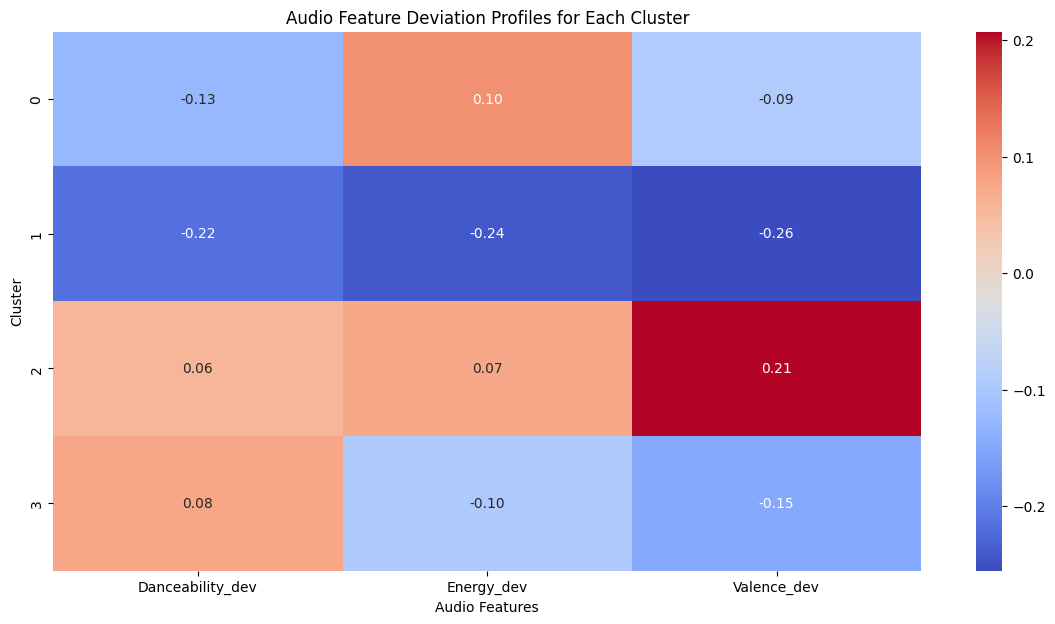

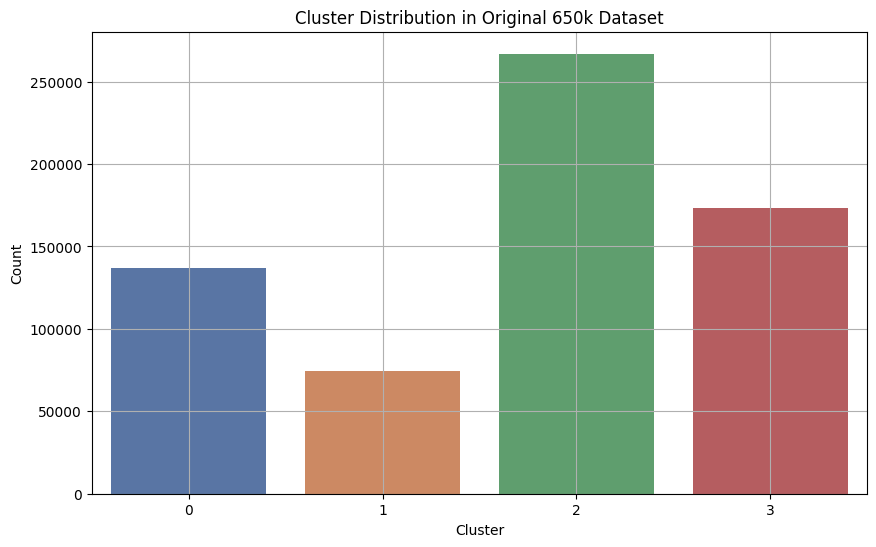

In [30]:
feature_centers = df_unique_avg_dev.groupby('cluster').mean(numeric_only=True)

dev_cols = [col for col in df_unique_avg_dev.columns if '_dev' in col]
cluster_profiles = feature_centers[dev_cols]

plt.figure(figsize=(14, 7))
sns.heatmap(
    cluster_profiles, 
    annot=True, 
    cmap='coolwarm', 
    fmt='.2f' 
)
plt.title('Audio Feature Deviation Profiles for Each Cluster')
plt.xlabel('Audio Features')
plt.ylabel('Cluster')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='cluster', data=df, palette='deep', order=sorted(df['cluster'].unique()))
plt.title('Cluster Distribution in Original 650k Dataset')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.grid(True)
plt.show()

--- Data head with new Cluster Names ---
   cluster evolution_cluster_name
0        2    Mainstream Follower
1        2    Mainstream Follower
2        0           Trend Setter
3        3   Experimental/Outlier
4        3   Experimental/Outlier

--- New Cluster Counts by Name ---
evolution_cluster_name
Mainstream Follower     266900
Experimental/Outlier    173584
Trend Setter            137019
Retro/Throwback          74433
Name: count, dtype: int64


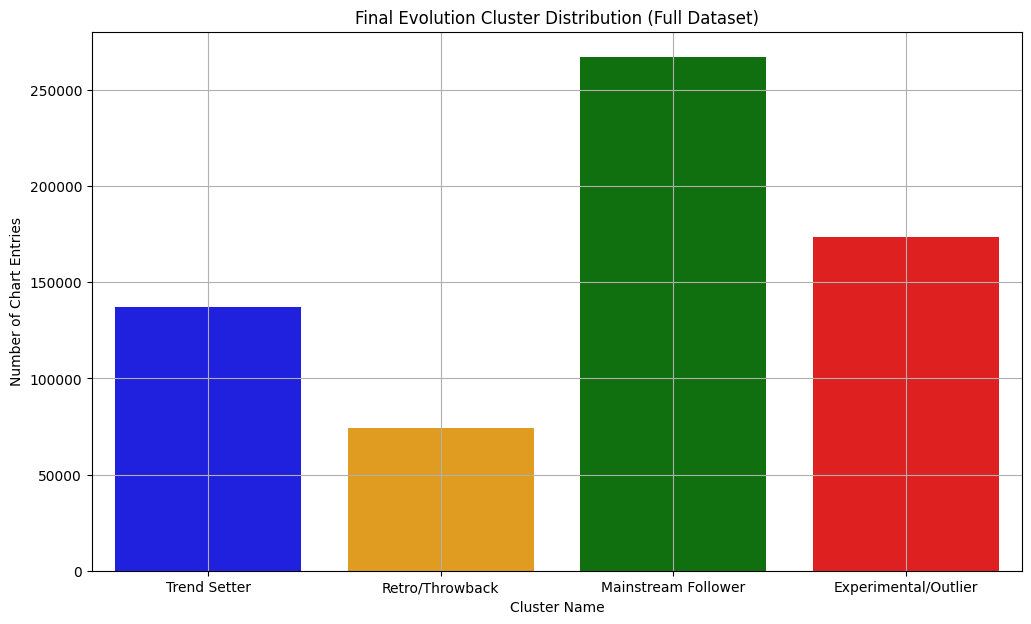

In [31]:
# --- 1. Define the Cluster Name Map ---
# This map is based on the analysis of your heatmap and count plot
evolution_cluster_name_map = {
    0: "Trend Setter",
    1: "Retro/Throwback",
    2: "Mainstream Follower",
    3: "Experimental/Outlier"
}

# --- 2. Apply the names to your DataFrame ---
# This assumes your cluster column is named 'cluster'
df['evolution_cluster_name'] = df['cluster'].map(evolution_cluster_name_map)

# --- 3. (Optional) Check the results ---
print("--- Data head with new Cluster Names ---")
print(df[['cluster', 'evolution_cluster_name']].head())

print("\n--- New Cluster Counts by Name ---")
print(df['evolution_cluster_name'].value_counts())

# --- 4. (Optional) Plot the named counts ---
# Define a color map for the new names
color_map = {
    "Mainstream Follower": "green",
    "Trend Setter": "blue",
    "Experimental/Outlier": "red",
    "Retro/Throwback": "orange"
}

plt.figure(figsize=(12, 7))
sns.countplot(
    x='evolution_cluster_name', 
    data=df, 
    palette=color_map,
    order=evolution_cluster_name_map.values()
)
plt.title('Final Evolution Cluster Distribution (Full Dataset)')
plt.xlabel('Cluster Name')
plt.ylabel('Number of Chart Entries')
plt.grid(True)
plt.show()

In [32]:
df.to_csv("Audio_evolution_clustering.csv", index=False)    

In [33]:
df

,Rank,Title,Artists,Date,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,...,# of Nationality,Nationality,Continent,Points (Total),Points (Ind for each Artist/Nat),id,Song URL,Year,cluster,evolution_cluster_name
0,1,Ella Baila Sola,"Eslabon Armado, Peso Pluma",2023-05-29,0.668,0.758,-5176.0,0.033,0.483,0.000,...,Nationality 1,Mexico,Latin-America,200,100.0,3qQbCzHBycnDpGskqOWY0E,https://open.spotify.com/track/3qQbCzHBycnDpGs...,2023,2,Mainstream Follower
1,1,Ella Baila Sola,"Eslabon Armado, Peso Pluma",2023-05-29,0.668,0.758,-5176.0,0.033,0.483,0.000,...,Nationality 2,Mexico,Latin-America,200,100.0,3qQbCzHBycnDpGskqOWY0E,https://open.spotify.com/track/3qQbCzHBycnDpGs...,2023,2,Mainstream Follower
2,2,WHERE SHE GOES,Bad Bunny,2023-05-29,0.652,0.800,-4019.0,0.061,0.143,0.629,...,Nationality 1,Puerto Rico,Latin-America,199,199.0,7ro0hRteUMfnOioTFI5TG1,https://open.spotify.com/track/7ro0hRteUMfnOio...,2023,0,Trend Setter
3,3,La Bebe - Remix,"Yng Lvcas, Peso Pluma",2023-05-29,0.812,0.479,-5678.0,0.333,0.213,0.000,...,Nationality 1,Mexico,Latin-America,198,99.0,2UW7JaomAMuX9pZrjVpHAU,https://open.spotify.com/track/2UW7JaomAMuX9pZ...,2023,3,Experimental/Outlier
4,3,La Bebe - Remix,"Yng Lvcas, Peso Pluma",2023-05-29,0.812,0.479,-5678.0,0.333,0.213,0.000,...,Nationality 2,Mexico,Latin-America,198,99.0,2UW7JaomAMuX9pZrjVpHAU,https://open.spotify.com/track/2UW7JaomAMuX9pZ...,2023,3,Experimental/Outlier
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651931,197,Oh Lord,MiC LOWRY,2017-01-01,0.273,0.794,-6644.0,0.068,0.022,0.000,...,Nationality 1,United Kingdom,Europe,4,4.0,1sTUEdVO85YU8Ymk2jeAls,https://open.spotify.com/track/1sTUEdVO85YU8Ym...,2017,0,Trend Setter
651932,198,Superstition - Single Version,Stevie Wonder,2017-01-01,0.650,0.658,-10908.0,0.085,0.089,0.004,...,Nationality 1,United States,Anglo-America,3,3.0,5lXcSvHRVjQJ3LB2rLKQog,https://open.spotify.com/track/5lXcSvHRVjQJ3LB...,2017,2,Mainstream Follower
651933,199,Secrets,The Weeknd,2017-01-01,0.665,0.771,-5779.0,0.053,0.016,0.000,...,Nationality 1,Canada,Anglo-America,2,2.0,3DX4Y0egvc0slLcLl31h2p,https://open.spotify.com/track/3DX4Y0egvc0slLc...,2017,2,Mainstream Follower
651934,200,Ni**as In Paris,"JAY-Z, Kanye West",2017-01-01,0.757,0.882,-6125.0,0.248,0.076,0.000,...,Nationality 1,United States,Anglo-America,1,1.0,2KpCpk6HjXXLb7nnXoXA5O,https://open.spotify.com/track/2KpCpk6HjXXLb7n...,2017,2,Mainstream Follower
